# Développement d'un Système de recommandation de livres

Ce système de recommandation a pour but de prédire la note ou la préférence qu'un utilisateur attibuerait à un livre (Ouvrage) en considérant ses anciennes notes ou préferences des différents ouvrages. Ce type de système de recommandation est beaucoup plus utilisé par certaines compagnies dans le but d'améliorer considérablement la qualité de leur services mais aussi le chiffre d'affaire.

Dans le cadre de ce travail, nous utilisons 2 bases de données (Fichiers CSV, contenant respectivement les informations suivantes :

1. fichier des notations (ratings.csv) (taille 68,7 MO) contenant les informations suivantes :  
    * user_id: identifiant utilisateur
    * book_id: identifiant livre 
    * rating : notation du livre, valeur allant de 1 à 5

2. fichier contenant des informations sur les livres (books.csv) ( taille 3,13 MO) contenant les informations suivantes :
    * auteurs, titres, notations, nombre de notation, date de publication, etc.

La travail est développé sous trois principaux points :

1. Chargement et analyse des données issus des fichiers des livres et ratings
2. Approches des plus proches voisins
3. Approche recommnedations collaborative
 

In [2]:
# Nous importons d'abord les principales librairies que nous allons utiliser

import numpy as np   # pour la gestion des données sous format matricielle
import pandas as pd  # pour la gestion des data frames
import matplotlib.pyplot as plt  # pour la visualisation dynamique

from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense # pour le développement de modèles CNN
from tensorflow.keras.models import Model

import os # pour les fichiers système
import warnings

warnings.filterwarnings('ignore') 
%matplotlib inline

 ## 1. Chargement et analyse des deux bases de données des livres et ratings

### 1.1 Analyse de la base de données  des notes "ratings"

In [3]:
#Chargement de  la base de données des ratings
ratings = pd.read_csv('data/ratings.csv')

In [4]:
ratings.head(10)

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3
5,2,26,4
6,2,315,3
7,2,33,4
8,2,301,5
9,2,2686,5


In [5]:
# dimension de la base de données
ratings.shape

(5976479, 3)

* La base de données de rating contient 5976479 lignes et les identifiants users et livres et ainsi que la note pour chaque livre

In [6]:
# Vérification si un utilisateur a noté un même livre plus d'une fois, dans ce cas, nous prendrons la note maximum
ratings_df = ratings.groupby(['user_id','book_id']).aggregate(np.max)

In [7]:
# Dans le cas présent, la longeur de ratings_df est égale à la longeur de ratings, donc, chaque livre a été noté une seul fois
# par un utilisateur

len(ratings_df)

5976479

* La longueur de  ratings_df est égale à la longueur de rating, donc chaque livre a été noté une fois par un utilisateur

In [370]:
# Inspection des données
ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [9]:
# Nombre total d'utilisateurs

n_users = len(ratings['user_id'].unique())
n_users

53424

* La base de données contient 53424 utilisateurs différents

In [373]:
# Nombre total de livres
n_books = len(ratings['book_id'].unique())
n_books

10000

* La base de données contient 10000 livres différents

In [374]:
#Analyse du pourcentage pour chaque note

count_ratings = ratings.groupby('rating').count()
count_ratings['perc_total']=round(count_ratings['user_id']*100/count_ratings['user_id'].sum(),1)

In [375]:
count_ratings

,user_id,book_id,perc_total
rating,,,
1,124195,124195,2.1
2,359257,359257,6.0
3,1370916,1370916,22.9
4,2139018,2139018,35.8
5,1983093,1983093,33.2


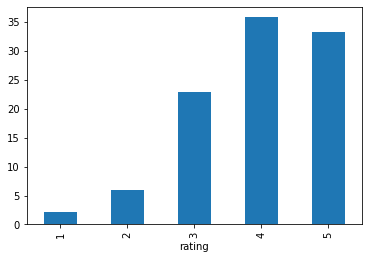

In [376]:
#Visualisation du pourcentage total pour chaque note

count_ratings['perc_total'].plot.bar()

* 68 % des livres sont notés au dessus de 4

In [10]:
# les dix premiers livres les mieux notés par l'utilisateur 2

ratings_2 = ratings.loc[ratings['user_id'] ==2].sort_values(by=['rating','book_id'], ascending=False).head(10)
ratings_2

,user_id,book_id,rating
3,2,9296,5
5694972,2,8855,5
11,2,8519,5
5694989,2,8014,5
5694984,2,7402,5
5695004,2,7233,5
5694988,2,6384,5
10,2,3753,5
9,2,2686,5
5695019,2,2166,5


In [381]:
# Les cinq utilisateurs ayant bien notés le livre dont l'ID est 9296

ratings_bookID9296 = ratings.loc[ratings['book_id'] == 9296].sort_values(by=['rating'], ascending=False).head(5)
ratings_bookID9296

,user_id,book_id,rating
3,2,9296,5
4003526,4170,9296,5
1311776,19182,9296,5
1322303,19245,9296,5
3867418,44428,9296,5


In [385]:
# Les 5 autres livres mieux notés par l'utilisateur dont l'ID est 4170

ratings_4170 = ratings.loc[ratings['user_id'] ==4170].sort_values(by=['rating','book_id'], ascending=False).head(10)
ratings_4170


,user_id,book_id,rating
3169459,4170,9688,5
4003526,4170,9296,5
3169457,4170,8296,5
4003534,4170,7770,5
4003519,4170,7382,5
4003535,4170,6988,5
3169458,4170,5387,5
4003527,4170,5050,5
4003537,4170,4735,5
4003522,4170,3419,5


L'utilisateur 2 et l'utilisateur 4170 ont tous rès bien noté le livre 9296. Cette liste de livres bien notés par l'utilisateur 4170 pourrait aussi ntéresser l'utilisateur 2.

Les modèles de  recommandation que l'on va développer au niveau des sections qui suivent s'appuient sur cette logique

### 1.2 Analyse de la base de données  des livres/ouvrages  "books"

In [11]:
#chargement du fichier de données

books_list = pd.read_csv('data/books.csv')

In [12]:
len(books_list)

10000

* La base de données des livres contient de 10000 livres

In [13]:
#inspection du data frame de livres

books_list.head(10)

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...
5,6,11870085,11870085,16827462,226,525478817,9.780525e+12,John Green,2012.0,The Fault in Our Stars,...,2346404,2478609,140739,47994,92723,327550,698471,1311871,https://images.gr-assets.com/books/1360206420m...,https://images.gr-assets.com/books/1360206420s...
6,7,5907,5907,1540236,969,618260307,9.780618e+12,J.R.R. Tolkien,1937.0,The Hobbit or There and Back Again,...,2071616,2196809,37653,46023,76784,288649,665635,1119718,https://images.gr-assets.com/books/1372847500m...,https://images.gr-assets.com/books/1372847500s...
7,8,5107,5107,3036731,360,316769177,9.780317e+12,J.D. Salinger,1951.0,The Catcher in the Rye,...,2044241,2120637,44920,109383,185520,455042,661516,709176,https://images.gr-assets.com/books/1398034300m...,https://images.gr-assets.com/books/1398034300s...
8,9,960,960,3338963,311,1416524797,9.781417e+12,Dan Brown,2000.0,Angels & Demons,...,2001311,2078754,25112,77841,145740,458429,716569,680175,https://images.gr-assets.com/books/1303390735m...,https://images.gr-assets.com/books/1303390735s...
9,10,1885,1885,3060926,3455,679783261,9.780680e+12,Jane Austen,1813.0,Pride and Prejudice,...,2035490,2191465,49152,54700,86485,284852,609755,1155673,https://images.gr-assets.com/books/1320399351m...,https://images.gr-assets.com/books/1320399351s...


In [14]:
# Le nombre de livres uniques au niveau du dataset.

len(books_list['book_id'].unique())

10000

In [15]:
# Extraction des composantes average_rating , ratings_count et authors pour quelques analyses

avg_BookRating = books_list[['book_id','original_title' ,'average_rating','ratings_count','authors']]

# Les dix livres les mieux notés
avg_BookRating.sort_values(by=['average_rating'], ascending=False).head(10)

,book_id,original_title,average_rating,ratings_count,authors
3627,3628,The Complete Calvin and Hobbes,4.82,28900,Bill Watterson
3274,3275,NaN,4.77,33220,"J.K. Rowling, Mary GrandPré"
861,862,Words of Radiance,4.77,73572,Brandon Sanderson
8853,8854,Mark of the Lion Trilogy,4.76,9081,Francine Rivers
7946,7947,NaN,4.76,8953,"Anonymous, Lane T. Dennis, Wayne A. Grudem"
4482,4483,It's a Magical World: A Calvin and Hobbes Coll...,4.75,22351,Bill Watterson
6360,6361,There's Treasure Everywhere: A Calvin and Hobb...,4.74,16766,Bill Watterson
421,422,Complete Harry Potter Boxed Set,4.74,190050,J.K. Rowling
3752,3753,"Harry Potter Collection (Harry Potter, #1-6)",4.73,24618,J.K. Rowling
6919,6920,The Indispensable Calvin and Hobbes: A Calvin ...,4.73,14597,Bill Watterson


In [16]:
# Les dix livres les moins bien notés et leurs auteurs

avg_BookRating.sort_values(by=['average_rating'], ascending=True).head(10)

,book_id,original_title,average_rating,ratings_count,authors
1792,1793,One Night @ The Call Center,2.47,40718,Chetan Bhagat
3549,3550,The Almost Moon,2.67,28299,Alice Sebold
8006,8007,The Finkler Question,2.76,9627,Howard Jacobson
9020,9021,Lost,2.80,12534,"Gregory Maguire, Douglas Smith"
4008,4009,Four Blondes,2.80,22278,Candace Bushnell
8165,8166,Parmi les dix milliers de choses,2.84,8458,Julia Pierpont
8873,8874,Tell-All,2.84,9733,Chuck Palahniuk
4282,4283,Revenge Wears Prada: The Devil Returns,2.84,19210,Lauren Weisberger
4613,4614,The Emperor's Children,2.93,15362,Claire Messud
8959,8960,The Red House,2.93,10621,Mark Haddon


In [17]:
# les 10 livres qui ont été notés par un plus grand nombre de lecteurs et leus auteurs

avg_BookRating.sort_values(by=['ratings_count'], ascending=False).head(10)

,book_id,original_title,average_rating,ratings_count,authors
0,1,The Hunger Games,4.34,4780653,Suzanne Collins
1,2,Harry Potter and the Philosopher's Stone,4.44,4602479,"J.K. Rowling, Mary GrandPré"
2,3,Twilight,3.57,3866839,Stephenie Meyer
3,4,To Kill a Mockingbird,4.25,3198671,Harper Lee
4,5,The Great Gatsby,3.89,2683664,F. Scott Fitzgerald
5,6,The Fault in Our Stars,4.26,2346404,John Green
6,7,The Hobbit or There and Back Again,4.25,2071616,J.R.R. Tolkien
7,8,The Catcher in the Rye,3.79,2044241,J.D. Salinger
9,10,Pride and Prejudice,4.24,2035490,Jane Austen
8,9,Angels & Demons,3.85,2001311,Dan Brown


## 2. Développement de modèles pour le système de recommandation

### 2.1 Quelques analyses et préparations des données

In [18]:
#fusion des data frames books et ratings

ratings_books = pd.merge(ratings,books_list, on = 'book_id')
ratings_books.head()

,user_id,book_id,rating,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,258,5,1232,1232,3209783,279,143034901,9.780143e+12,"Carlos Ruiz Zafón, Lucia Graves",...,263685,317554,24652,4789,11769,42214,101612,157170,https://images.gr-assets.com/books/1344545047m...,https://images.gr-assets.com/books/1344545047s...
1,11,258,3,1232,1232,3209783,279,143034901,9.780143e+12,"Carlos Ruiz Zafón, Lucia Graves",...,263685,317554,24652,4789,11769,42214,101612,157170,https://images.gr-assets.com/books/1344545047m...,https://images.gr-assets.com/books/1344545047s...
2,143,258,4,1232,1232,3209783,279,143034901,9.780143e+12,"Carlos Ruiz Zafón, Lucia Graves",...,263685,317554,24652,4789,11769,42214,101612,157170,https://images.gr-assets.com/books/1344545047m...,https://images.gr-assets.com/books/1344545047s...
3,242,258,5,1232,1232,3209783,279,143034901,9.780143e+12,"Carlos Ruiz Zafón, Lucia Graves",...,263685,317554,24652,4789,11769,42214,101612,157170,https://images.gr-assets.com/books/1344545047m...,https://images.gr-assets.com/books/1344545047s...
4,325,258,4,1232,1232,3209783,279,143034901,9.780143e+12,"Carlos Ruiz Zafón, Lucia Graves",...,263685,317554,24652,4789,11769,42214,101612,157170,https://images.gr-assets.com/books/1344545047m...,https://images.gr-assets.com/books/1344545047s...


In [19]:
# On retient les  livres qui ont été notés 4 et plus

ratings_books = pd.merge(ratings,books_list, on = 'book_id')
ratings_books = ratings_books[ratings_books['rating'] > 4]
ratings_books.head()

,user_id,book_id,rating,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,258,5,1232,1232,3209783,279,143034901,9.780143e+12,"Carlos Ruiz Zafón, Lucia Graves",...,263685,317554,24652,4789,11769,42214,101612,157170,https://images.gr-assets.com/books/1344545047m...,https://images.gr-assets.com/books/1344545047s...
3,242,258,5,1232,1232,3209783,279,143034901,9.780143e+12,"Carlos Ruiz Zafón, Lucia Graves",...,263685,317554,24652,4789,11769,42214,101612,157170,https://images.gr-assets.com/books/1344545047m...,https://images.gr-assets.com/books/1344545047s...
10,499,258,5,1232,1232,3209783,279,143034901,9.780143e+12,"Carlos Ruiz Zafón, Lucia Graves",...,263685,317554,24652,4789,11769,42214,101612,157170,https://images.gr-assets.com/books/1344545047m...,https://images.gr-assets.com/books/1344545047s...
11,579,258,5,1232,1232,3209783,279,143034901,9.780143e+12,"Carlos Ruiz Zafón, Lucia Graves",...,263685,317554,24652,4789,11769,42214,101612,157170,https://images.gr-assets.com/books/1344545047m...,https://images.gr-assets.com/books/1344545047s...
13,752,258,5,1232,1232,3209783,279,143034901,9.780143e+12,"Carlos Ruiz Zafón, Lucia Graves",...,263685,317554,24652,4789,11769,42214,101612,157170,https://images.gr-assets.com/books/1344545047m...,https://images.gr-assets.com/books/1344545047s...


In [20]:
#Top 10 des livres qui ont été très bien notés par les utilisateurs qui ont bien noté ( note > 4) un livre donné

def get_other_books(book_id):
    
    #Utilisateurs qui ont noté le livre
    df_books_users_series = ratings_books.loc[ratings_books['book_id']== book_id]['user_id']
    
    #conversion en data frame
    df_books_users = pd.DataFrame(df_books_users_series,columns=['user_id'])
    
    #liste de tous les autres livre qui ont été bien noté par ces utilisateurs
    other_books = pd.merge(df_books_users,ratings_books,on='user_id')
    
    #liste des livres qui ont été les mieux notés par ces utilisateurs
    other_users_liked = pd.DataFrame(other_books.groupby('book_id')['user_id'].count()).sort_values('user_id',ascending=False)   
    
    return other_users_liked[:10]
    
 

In [21]:
# Top 10 des livres qui ont été mieux notés par les utilisateurs qui ont bien notés le livre 1232

get_other_books(1232)

,user_id
book_id,
1232,399
1226,354
1181,345
1067,345
1151,342
1267,342
996,339
1390,325
912,324


In [22]:
#Création de la matrice avec des books ID en ligne et les user ID en colonnes
#On remplace les NAN par 0

books_wide = ratings_books.pivot(index = 'book_id', columns = 'user_id', values = 'rating').fillna(0)
books_wide.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,53415,53416,53417,53418,53419,53420,53421,53422,53423,53424
book_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,5.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,5.0,5.0,5.0,5.0,5.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,5.0
5,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2.2 Le modèle des K plus proches voisins 

Pour déterminer quels sont les voisins les plus pertinents à sélectionner, on utilise généralement l’algorithme du k-proche voisins (k nearest -neighbor (k-NN)) qui permet de sélectionner seulement les k meilleurs voisins ayant la plus haute valeur de corrélation.

In [23]:
from sklearn.neighbors import NearestNeighbors

#specification des paramètres du modèle
model_knn = NearestNeighbors(metric='cosine',algorithm='brute')

#fit model au data set
model_knn.fit(books_wide)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [24]:
#top 10 de livres les plus proches à un livre donné

def print_similar_books(query_index) :
    #get the list of user ratings for a specific userId
    query_index_books_ratings = books_wide.loc[query_index,:].values.reshape(1,-1)
    #get the closest 10 books and their distances from the book specified
    distances,indices = model_knn.kneighbors(query_index_books_ratings,n_neighbors = 11) 
    #write a lopp that prints the similar books for a specified movie.
    for i in range(0,len(distances.flatten())):
        #get the title of the random book that was chosen
        get_book = books_list.loc[books_list['book_id']==query_index]['title']
        #for the first book in the list i.e closest print the title
        if i==0:
            print('Recommendations for {0}:\n'.format(get_book))
        else :
            #get the indiciees for the closest books
            indices_flat = indices.flatten()[i]
            #get the title of the book
            get_book = books_list.loc[books_list['book_id']==books_wide.iloc[indices_flat,:].name]['title']
            #print the book
            print('{0}: {1}, with distance of {2}:'.format(i,get_book,distances.flatten()[i]))

In [25]:
print_similar_books(1232)

Recommendations for 1231    Hard Eight (Stephanie Plum, #8)
Name: title, dtype: object:

1: 1266    To the Nines (Stephanie Plum, #9)
Name: title, dtype: object, with distance of 0.10011839768517716:
2: 1225    Seven Up (Stephanie Plum, #7)
Name: title, dtype: object, with distance of 0.11166805859780171:
3: 1180    High Five (Stephanie Plum, #5)
Name: title, dtype: object, with distance of 0.13857073719448754:
4: 1150    Hot Six (Stephanie Plum, #6)
Name: title, dtype: object, with distance of 0.1396165155817154:
5: 1389    Eleven on Top (Stephanie Plum, #11)
Name: title, dtype: object, with distance of 0.1412837352570373:
6: 1066    Four to Score (Stephanie Plum, #4)
Name: title, dtype: object, with distance of 0.16121680860784016:
7: 995    Three to Get Deadly (Stephanie Plum, #3)
Name: title, dtype: object, with distance of 0.18252474527332851:
8: 1605    Ten Big Ones (Stephanie Plum, #10)
Name: title, dtype: object, with distance of 0.1854920110628402:
9: 1626    Twelve Sharp (Ste

In [26]:
print_similar_books(1)

Recommendations for 0    The Hunger Games (The Hunger Games, #1)
Name: title, dtype: object:

1: 16    Catching Fire (The Hunger Games, #2)
Name: title, dtype: object, with distance of 0.4199700493283224:
2: 19    Mockingjay (The Hunger Games, #3)
Name: title, dtype: object, with distance of 0.5150431324905729:
3: 1    Harry Potter and the Sorcerer's Stone (Harry P...
Name: title, dtype: object, with distance of 0.5684364433283482:
4: 11    Divergent (Divergent, #1)
Name: title, dtype: object, with distance of 0.6155895015117284:
5: 24    Harry Potter and the Deathly Hallows (Harry Po...
Name: title, dtype: object, with distance of 0.6686670490805615:
6: 30    The Help
Name: title, dtype: object, with distance of 0.675850821526552:
7: 2    Twilight (Twilight, #1)
Name: title, dtype: object, with distance of 0.6769374739681291:
8: 26    Harry Potter and the Half-Blood Prince (Harry ...
Name: title, dtype: object, with distance of 0.6815749886398936:
9: 20    Harry Potter and the Order o

### Commentaires : 
Nous ne disposons pas au niveau de la base de données d'informations sur les genres des livres. Ceci aurait parmis de faire une recommendation selon les genres des livres. Dans ce cas, nous nous limitons donc à la recommandation sur base du titre de livres.

### 2.3 Recommendation basée sur une approche collaborative

L'approche collaborative consiste à extraire des features latentes pour les livres et les utilisateurs grâce aux réseaux de neurones (embedding) et ensuite les recommendations se font à partir des features définies pour les livres et utilisateurs;

le filtrage collaboratif est sous-jacent aux systèmes de recommandation. Il regroupe des techniques qui visent à opérer une sélection sur les éléments à présenter aux utilisateurs (filtrage) en se basant sur le comportement et les goûts exprimés de très nombreux autres utilisateurs

In [27]:
from sklearn.model_selection import train_test_split

#Constitution de la base de données d'entrainement (80%) et de la base de données test(20%)
# sur base de la base de données ratings

train, test = train_test_split(ratings, test_size=0.2, random_state=42)

In [28]:
train.head(10)

,user_id,book_id,rating
1701724,10714,7164,3
5361971,48091,2213,3
3243372,9809,5769,4
1808828,25191,86,5
5142988,25441,4884,3
2221808,29639,20,2
2116592,28648,2007,5
5389438,53402,1122,4
3680082,42999,45,5
3849434,44240,373,3


In [30]:
test.head(10)

,user_id,book_id,rating
3623535,42562,2757,3
3985638,43232,134,4
2983642,37244,1463,5
5812251,53366,71,2
2208852,29634,3339,4
342896,2268,2250,4
2932617,36766,39,4
2433943,18377,1544,4
5196212,41168,182,5
908625,14453,35,4


In [31]:
n_users, n_books = len(ratings.user_id.unique()), len(ratings.book_id.unique())
#nombre utilisateurs
n_users

53424

In [32]:
from tensorflow.keras.layers import Concatenate

# creation du path pour le book embedding
book_input = Input(shape=[1], name="Book-Input")
book_embedding = Embedding(n_books+1, 5, name="Book-Embedding")(book_input)
book_vec = Flatten(name="Flatten-Books")(book_embedding)

# creation du path pour le user embedding 
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# concatenation des  features
conc_features = Concatenate()([book_vec, user_vec])

# ajout des fully-connected-layers
fc1 = Dense(128, activation='relu')(conc_features)
fc2 = Dense(32, activation='relu')(fc1)
out = Dense(1)(fc2)

# Creation et compilation du modèle
model = Model([user_input, book_input], out)
model.compile('adam', 'mean_squared_error')

Train on 4781183 samples
Epoch 1/5
4781183/4781183 [==============================] - ETA: 0s - loss: 0.774 - 554s 116us/sample - loss: 0.7749
Epoch 2/5
4781183/4781183 [==============================] - 598s 125us/sample - loss: 0.7269
Epoch 3/5
4781183/4781183 [==============================] - 598s 125us/sample - loss: 0.7062
Epoch 4/5
4781183/4781183 [==============================] - 592s 124us/sample - loss: 0.6860
Epoch 5/5
4781183/4781183 [==============================] - 597s 125us/sample - loss: 0.6720


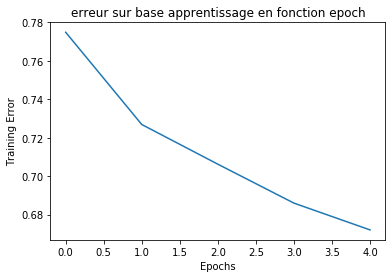

In [33]:
from tensorflow.keras.models import load_model

if os.path.exists('recommendation_model.h5'):
    model = load_model('recommendation_model.h5')
else:
    history = model.fit([train.user_id, train.book_id], train.rating, epochs=5, verbose=1)
    model.save('recommendation_model.h5')
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")
    plt.title("erreur sur base apprentissage en fonction epoch")

In [34]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Book-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
User-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Book-Embedding (Embedding)      (None, 1, 5)         50005       Book-Input[0][0]                 
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         267125      User-Input[0][0]                 
______________________________________________________________________________________________

In [35]:
model.evaluate([test.user_id, test.book_id], test.rating)

1195296/1195296 [==============================] - 54s 45us/sample - loss: 0.6919


0.6918901889870815

* Le niveau d'erreur est de 0.69 sur la base de test 

In [36]:
# Prédictions
predictions = model.predict([test.user_id.head(10), test.book_id.head(10)])
[print(predictions[i], test.rating.iloc[i]) for i in range(0,10)]

[3.2538848] 3
[3.1452231] 4
[4.8254166] 5
[1.9790981] 2
[3.3913803] 4
[3.5932014] 4
[4.3267603] 4
[4.069909] 4
[4.4159527] 5
[3.5807862] 4


[None, None, None, None, None, None, None, None, None, None]

* Affichage des predictions des 10 premiers users


### Visualisation des Embeddings

Les embeddings sont les poids qui sont apprises pour representer certaines variables spécifiques. Dans le cas de cette étude ce sont les livres(ouvrages) et les utilisateurs(users). On  les utilise de ce fait pour avoir de meilleurs résultats dans la résolution du problème.

In [39]:
# Extract embeddings
book_em = model.get_layer('Book-Embedding')
book_em_weights = book_em.get_weights()[0]

In [40]:
#Synthèse des embeddings pour les livres
pd.DataFrame(book_em_weights).describe()

,0,1,2,3,4
count,10001.000000,10001.000000,10001.000000,10001.000000,10001.000000
mean,-0.409630,-0.065679,0.022570,-0.637053,1.177367
std,0.531558,0.739957,0.660978,0.653141,0.850509
min,-2.340590,-2.564034,-2.522973,-3.057777,-2.350632
25%,-0.767798,-0.572188,-0.460058,-1.095643,0.592659
50%,-0.430934,-0.025432,0.041602,-0.642681,1.163429
75%,-0.074859,0.468603,0.536758,-0.170725,1.717259
max,1.927849,2.643591,1.948396,1.662681,5.144882


#### Visualisation des embedding des livres par PCA

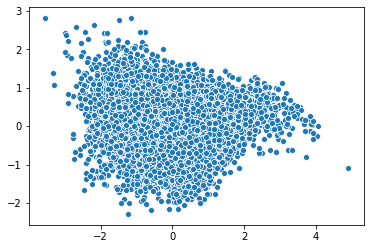

In [43]:
# Visualisation des embedding via le PCA

from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [44]:
book_em_weights = book_em_weights / np.linalg.norm(book_em_weights, axis = 1).reshape((-1, 1))
book_em_weights[0][:10]
np.sum(np.square(book_em_weights[0]))

1.0

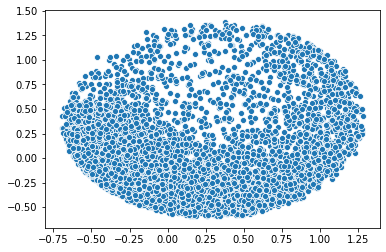

In [45]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

### Visualisation des embedding des livre par TSNE

In [46]:
#Avec TSNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tnse_results = tsne.fit_transform(book_em_weights)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10001 samples in 0.006s...
[t-SNE] Computed neighbors for 10001 samples in 0.830s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10001
[t-SNE] Computed conditional probabilities for sample 2000 / 10001
[t-SNE] Computed conditional probabilities for sample 3000 / 10001
[t-SNE] Computed conditional probabilities for sample 4000 / 10001
[t-SNE] Computed conditional probabilities for sample 5000 / 10001
[t-SNE] Computed conditional probabilities for sample 6000 / 10001
[t-SNE] Computed conditional probabilities for sample 7000 / 10001
[t-SNE] Computed conditional probabilities for sample 8000 / 10001
[t-SNE] Computed conditional probabilities for sample 9000 / 10001
[t-SNE] Computed conditional probabilities for sample 10000 / 10001
[t-SNE] Computed conditional probabilities for sample 10001 / 10001
[t-SNE] Mean sigma: 0.098199
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.259865
[t-SNE] KL

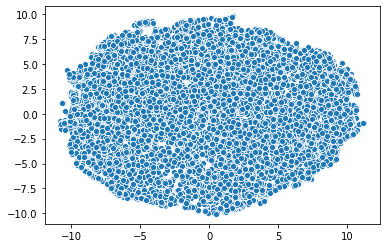

In [47]:
sns.scatterplot(x=tnse_results[:,0], y=tnse_results[:,1])

### 2.4 Faire une recommandation pour un utilisateur :

Dans le cadre d'une recommandation, nous analysons la recommandation des livres pour le premier utilisateur à l'aide du modèle
développé avec les réseau de neuronnes pour une approche collabortive.

In [88]:
# Création d'un dataset pour créer des recommendations pour le premier utilisateur
book_data = np.array(list(set(ratings.book_id)))
book_data[:5]

array([1, 2, 3, 4, 5])

In [89]:
user = np.array([ 1 for i in range(len(book_data))])
user[:5]

array([1, 1, 1, 1, 1])

In [90]:
predictions = model.predict([user, book_data])
predictions = np.array([a[0] for a in predictions])
recommended_book_ids = (-predictions).argsort()[:5]
recommended_book_ids

array([3627, 3247, 1009, 3490, 7882], dtype=int64)

In [93]:
# Scores predits
predictions[recommended_book_ids]

array([4.723775 , 4.589015 , 4.559012 , 4.540312 , 4.5401907],
      dtype=float32)

In [94]:
# La liste des 5 premiers livres à recommander à l'utilisateur dont l'id est 1
books_list[books_list['book_id'].isin(recommended_book_ids)]

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
1008,1009,15815333,15815333,21541829,34,1594488398,9.781594e+12,Meg Wolitzer,2013.0,The Interestings,...,76566,84976,9534,3532,9398,25476,31182,15388,https://images.gr-assets.com/books/1451446889m...,https://images.gr-assets.com/books/1451446889s...
3246,3247,3977,3977,1882574,58,553572946,9.780554e+12,Dan Simmons,1996.0,Endymion,...,30664,33572,969,273,1201,5556,12997,13545,https://images.gr-assets.com/books/1329611385m...,https://images.gr-assets.com/books/1329611385s...
3489,3490,20767918,20767918,40105061,7,1455521191,9.781456e+12,David Baldacci,2014.0,The Escape,...,18073,29683,2317,265,771,4660,12864,11123,https://images.gr-assets.com/books/1404163742m...,https://images.gr-assets.com/books/1404163742s...
3626,3627,7592279,7592279,9985502,37,1741664489,9.781742e+12,John Flanagan,2011.0,NaN,...,29397,33357,1089,226,618,3569,9564,19380,https://images.gr-assets.com/books/1446448563m...,https://images.gr-assets.com/books/1446448563s...
7881,7882,10374638,10374638,13897390,36,174275001X,9.781743e+12,Deborah Rodriguez,2011.0,A Cup of Friendship,...,7607,12693,1571,434,1303,3880,4797,2279,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...


### Conclusions 

Le filtrage collaboratif  est un algorithme de recommandation, qui consiste à prédire les livres que des utilisateurs apprécieront dans le futur.
Le filtrage collaboratif est une approche simple à appréhender et qui permet de concevoir des outils de personnalisation pertinents, en effet il est possible d'ajuster à tout moment le nombre de livres à recommender.

Le filtrage collaboratif est une méthode idéale pour réduire la dimension du problème de recommendation et continuer de fournir des résultats pertinents même en présence de millions d’utilisateurs.

Dans notre cas l'approche de recommendation collaborative est plus adaptée vu la taille de l'enchantillon et peu d'information sur les contenus des livres.
